In [105]:
import numpy as np
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import torch.optim.lr_scheduler as scheduler
import random
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Imports to view data
import cv2
from glob import glob

from google.colab import files, drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [106]:
cuda = torch.cuda.is_available()
print(cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


In [107]:
# Image transformation for training, validation and testing

# Training transformation
# 1. Resize - All the pre trained models are trained with 224 X 224 image size
# 2. Normalization - Standard values suggest by PyTorch
# 3. Random horzontal flip with 0.5 probability
# 4. Random rotation with +/- 5 degree angle
# 5. Conversion to torch tensor
train_transform = transforms.Compose([transforms.Resize((64, 64), interpolation=2),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomRotation(5, resample=False, expand=False),
                                    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
# Validation transformation
# Necessary transforms only
validation_transform = transforms.Compose([transforms.Resize((64, 64), interpolation=2),
                                    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
# Test transformation
# Necessary transforms only
test_transform = transforms.Compose([transforms.Resize((64, 64), interpolation=2),
                                    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [108]:
# Train dataset and dataloader
dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/asl_alphabet_train', transform = validation_transform)
train_size = int(0.3*len(dataset)) #40% of data for training
val_size = int(0.1*len(dataset))
random_size = len(dataset)-train_size-val_size

train_dataset, val_dataset, temp_df = torch.utils.data.random_split(dataset,[train_size, val_size, random_size]) #we get two datasets

#create training loader and validation loader
train_loader=DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers= 8)
val_loader=DataLoader(val_dataset, batch_size = 128, shuffle=True, num_workers= 8)

# Test dataset and dataloader
test_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/asl_alphabet_test', transform = test_transform )
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=8)

train_dir="/content/drive/MyDrive/asl_alphabet_train"
CLASSES = [folder[len(train_dir) + 1:] for folder in glob(train_dir + '/*')]
CLASSES.sort()

In [109]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

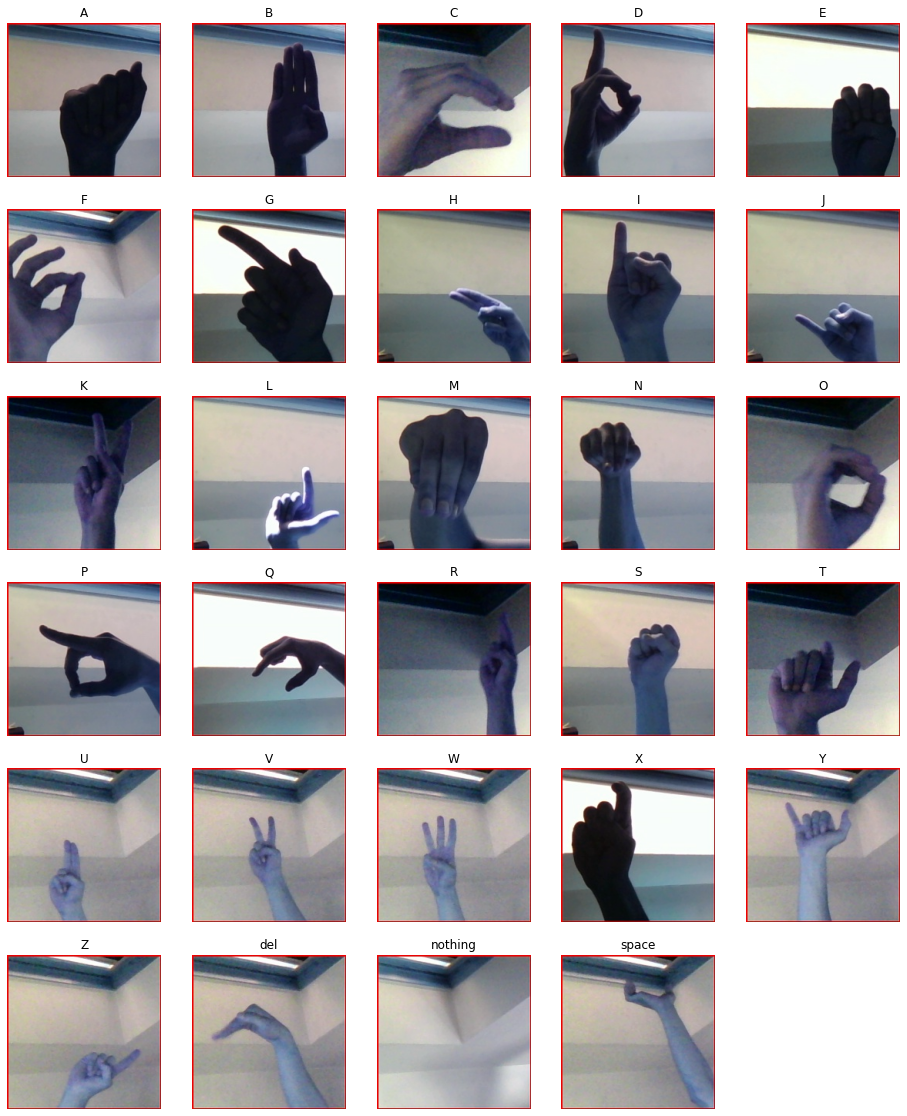

In [110]:
plot_one_sample_of_each(train_dir)

In [111]:
# Residual block
class BasicBlock(nn.Module):
    def __init__(self, channel_size, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(channel_size, channel_size, kernel_size=3, padding=2, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_size)
        self.conv2 = nn.Conv2d(channel_size, channel_size, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_size)
        self.conv3 = nn.Conv2d(channel_size, channel_size, kernel_size=3, padding=0, stride=stride, bias=False)
        self.bn3 = nn.BatchNorm2d(channel_size)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += identity
        out = F.relu(out)
        return out


In [112]:
#((ip size (64)+2p-k.s.)/stride)+1

In [113]:
# Custom CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
    
        self.layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            
            BasicBlock(32),
            BasicBlock(32),


            nn.Conv2d(32, 64, kernel_size=5, stride=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),

            BasicBlock(64),
            BasicBlock(64),
            
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            
            BasicBlock(128),
            BasicBlock(128),
            
            nn.Conv2d(128, 256, kernel_size=2, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),

            BasicBlock(256),
            BasicBlock(256),
            
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=2, stride=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            
            BasicBlock(512),
            BasicBlock(512),
            
            nn.AvgPool2d(kernel_size=2, stride=2)
    
        )
        self.linear = nn.Sequential(
            nn.Linear(512,29)
            #nn.Linear(512,29)
        )
    
    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = self.linear(x)
        
        return x

net = CNN().to(device)
print(net)

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=

In [114]:
model=CNN()
# Defining an optimizer
learning_rate = 0.001
optimizer_adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate)

optimizer = optimizer_adam

#Defining a learning rate scheduler
#scheduler_Multistep = scheduler.MultiStepLR(optimizer, milestones = [10, 20, 25, 30], gamma = 0.1)
scheduler_Step = scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
scheduler = scheduler_Step

# Defining a criterion
criterion = nn.CrossEntropyLoss()

# Setting training epochs
epochs = 5

In [115]:
class RunModel():
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, scheduler, criterion, numEpochs):
        self.net = model.double()
        self.train_loader = train_loader
        self.dev_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.numEpochs = numEpochs
        self.main()

    def set_device(self):
        # Method for setting device type if GPU is available
        if torch.cuda.is_available():
            self.device=torch.device('cuda')
            
        else:
            self.device=torch.device('cpu')

    def train_model(self):
        # Method for training the model
        self.net.train()
        self.training_loss = []
        self.training_acc = []
        self.dev_loss = []
        self.dev_accuracy = []
        total_predictions = 0.0
        correct_predictions = 0.0
        prev_dev_acc = 0
        print('Training the model...')

        for epoch in range(self.numEpochs):
            
            start_time = time.time()
            self.net.train()
            print('Epoch_Number: ',epoch)
            running_loss = 0.0
            

            for batch_idx, (data, target) in enumerate(self.train_loader):   

                self.optimizer.zero_grad() 
                data = data.double().to(self.device)
                target = target.to(self.device) 
                outputs = self.net(data)

                
                loss = self.criterion(outputs, target.long())
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += target.size(0)
                correct_predictions += (predicted == target).sum().item()


                
                running_loss += loss.item()
                loss.backward()
                self.optimizer.step()
        
            
            running_loss /= len(self.train_loader)              
            self.training_loss.append(running_loss)
            print('Training Loss: ', running_loss)
                
            acc = (correct_predictions/total_predictions)*100.0
            self.training_acc.append(acc)
            print('Training Accuracy: ', acc, '%')

            dev_loss,dev_acc = self.validate_model()
    
            if self.scheduler != None :

                self.scheduler.step()
                print('Current scheduler status: ', self.optimizer)
            
            end_time = time.time()
            print( 'Epoch Time: ',end_time - start_time, 's')
            

            self.dev_loss.append(dev_loss)
            self.dev_accuracy.append(dev_acc)

            if dev_acc > prev_dev_acc:
                path = 'model_parameters.pth'
                torch.save(self.net.state_dict(),path)
                print('Saving model parameters...')
                prev_dev_acc = dev_acc

            print('#'*50)
    

    def validate_model(self):

        with torch.no_grad():
            self.net.eval()
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        acc = 0
        self.actual = []
        self.predict = []
        

        for batch_idx, (data, target) in enumerate(self.dev_loader): 

            data = data.double().to(self.device)
            target = target.to(self.device)
            outputs = self.net(data)
            loss = self.criterion(outputs, target.long())
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
            self.predict.append(predicted.detach().cpu().numpy())
            self.actual.append(target.detach().cpu().numpy())
  
        running_loss /= len(self.dev_loader)
        print('Validation Loss: ', running_loss)

            
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Accuracy: ', acc, '%')
        
        return running_loss,acc

    def get_loss_graph(self):

        # Method for showing and saving the loss graph in the root directory

        plt.figure(figsize=(8,8))
        plt.plot(self.training_loss,label='Training Loss')
        plt.plot(self.dev_loss,label='Validation Loss')
        plt.legend()
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.savefig('loss.png')
    
    def get_accuracy_graph(self):

        # Method for showing and saving the accuracy graph in the root directory

        plt.figure(figsize=(8,8))
        plt.plot(self.training_acc,label='Training Accuracy')
        plt.plot(self.dev_accuracy,label='Validation Accuracy')
        plt.legend()
        plt.title('Model accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('acc')
        plt.savefig('accuracy.png')
    
    def get_confusion_matrix(self):

        # Method for getting the confusion matrix for classification problem
        print('Confusion Matix: ')

        result = confusion_matrix(np.concatenate(np.array(self.predict)), np.concatenate(np.array(self.actual)))
        print(result)

    def main(self):

        self.set_device()

        self.net.to(self.device)

        self.train_model()           # training the model

        self.get_loss_graph()

        self.get_accuracy_graph()    # saving the accuracy graph

        self.get_confusion_matrix()  #cm

    
    def test(self):

        with torch.no_grad():
            self.net.eval()
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        acc = 0
        self.actual = []
        self.predict = []

        for batch_idx, (data, target) in enumerate(self.test_loader): 

            data = data.double().to(self.device)
            target = target.to(self.device)
            outputs = self.net(data)


            loss = self.criterion(outputs, target.long())
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
            self.predict.append(predicted.detach().cpu().numpy())

        running_loss /= len(self.test_loader)
        print('Test Loss: ', running_loss)

            
        acc = (correct_predictions/total_predictions)*100.0
        print('Test Accuracy: ', acc, '%')


Training the model...
Epoch_Number:  0
Training Loss:  2.132753890328564
Training Accuracy:  35.34329770871948 %
Validation Loss:  0.9869365628917564
Validation Accuracy:  64.4581164221486 %
Current scheduler status:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
Epoch Time:  1440.9251999855042 s
Saving model parameters...
##################################################
Epoch_Number:  1
Training Loss:  0.5768794678747202
Training Accuracy:  57.51469022360689 %
Validation Loss:  0.36825385990570736
Validation Accuracy:  87.50591575958353 %
Current scheduler status:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
Epoch Time:  1328.2683272361755 s
Saving model parameters...
##################################################
Epoch_Number:  2
Training Loss:  0.31457005536493343
Training Accuracy:  67.9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


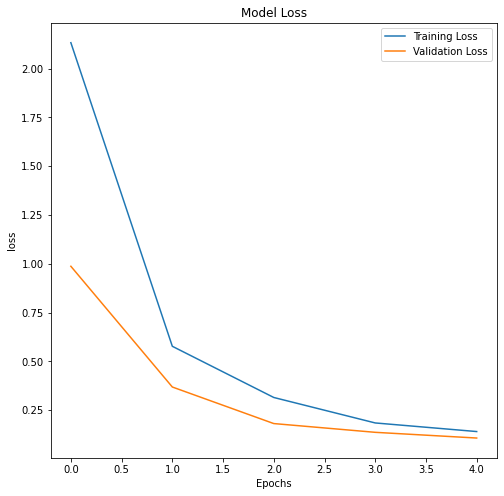

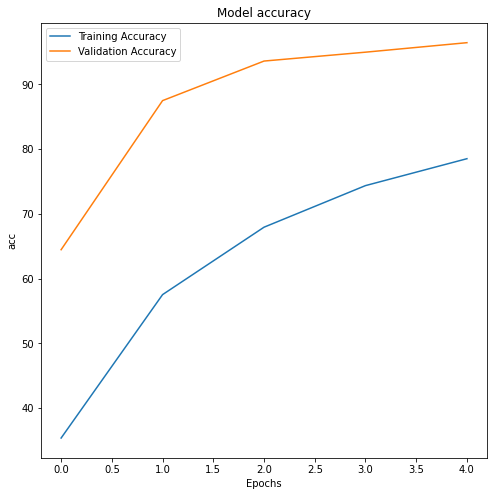

In [116]:
#training
MODEL = RunModel(model, train_loader, val_loader, test_loader, optimizer, scheduler, criterion, epochs)

In [118]:
# Mapping
print('\n')
print('Mapping: ')
print(dataset.class_to_idx)

MODEL.test()



Mapping: 
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Test Loss:  0.18473799907123584
Test Accuracy:  96.7741935483871 %


In [ ]:
!nvidia-smi
